# Sendy Logistics Challenge: 


# Challenge Description<br>

Sendy is hosting a Zindi challenge in partnership with insight2impact facility to predict the estimated delivery time of orders, from the driver pickup point to the point of arrival at the final destination.


The solution will help Sendy improve the communication with customers and improve the reliability of its service, which will ultimately improve the customer experience. Moreover, the solution would allow Sendy to realize cost savings and eventually reduce business costs by enhancing resource management and order scheduling planning.

# Notebook Outline

  1. Package Installation
  2. Importing Libraries
  3. Importing Data
  4. Data Cleaning and Formating
  5. Exploratory Data Analysis
  6. Feature Engineering and Selection
  7. Model Selection & Parameter Tuning
  8. Model Evaluation
  9. Submission 
  10. References

## 1. Package Installation

In [1]:
!pip install catboost
!pip install category_encoders

## 2. Importing Libraries

In [4]:
!pip install plotly_express==0.4.0
!pip install plotly

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#for some statistics & math
import math
from scipy import stats
from scipy.stats import norm, skew 

#To deal with warnings
import warnings
warnings.filterwarnings("ignore")

# Modelling
import category_encoders as ce
from sklearn.decomposition import PCA
from geopy.distance import vincenty

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, RobustScaler # For normalization
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.cluster import MiniBatchKMeans


#from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error as MSE
rs = 50

## 3. Importing Data

In [3]:
#Now let's import datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
riders = pd.read_csv("Riders.csv")
dictionary = pd.read_csv('VariableDefinitions.csv')

In [4]:
# Viewing the datasets
display(train.head(3))
display(test.head(3))
display(riders.head(3))
display(dictionary.head())

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26


,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466


,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31


## 4. Data Cleaning and Formatting

### 4.1. Fixing Messy Column names

In [5]:
def column_name_fix(input_df):
    input_df.columns = input_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('=', '_')
    input_df.columns = input_df.columns.str.replace('__', '_')
    input_df.columns = input_df.columns.str.replace('(', '').str.replace(')', '')
    input_df.columns = input_df.columns.str.replace('__', '_')
    display(input_df.columns)

In [6]:
# train dataset
column_name_fix(train)

#test dataset
column_name_fix(test)

#riders dataset
column_name_fix(riders)

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_day_of_month',
       'placement_weekday_mo_1', 'placement_time', 'confirmation_day_of_month',
       'confirmation_weekday_mo_1', 'confirmation_time',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'arrival_at_pickup_time', 'pickup_day_of_month', 'pickup_weekday_mo_1',
       'pickup_time', 'arrival_at_destination_day_of_month',
       'arrival_at_destination_weekday_mo_1', 'arrival_at_destination_time',
       'distance_km', 'temperature', 'precipitation_in_millimeters',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id', 'time_from_pickup_to_arrival'],
      dtype='object')

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_day_of_month',
       'placement_weekday_mo_1', 'placement_time', 'confirmation_day_of_month',
       'confirmation_weekday_mo_1', 'confirmation_time',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'arrival_at_pickup_time', 'pickup_day_of_month', 'pickup_weekday_mo_1',
       'pickup_time', 'distance_km', 'temperature',
       'precipitation_in_millimeters', 'pickup_lat', 'pickup_long',
       'destination_lat', 'destination_long', 'rider_id'],
      dtype='object')

Index(['rider_id', 'no_of_orders', 'age', 'average_rating', 'no_of_ratings'], dtype='object')

### 4.2. Addressing Missing Values  & Unique Values

A **drop_columns** function will be employed to remove any column from the dataframes which has a percentage of missing values greater than a specified `cutoff threshold value` and `unique value` count less than the specified.

In [7]:
def drop_columns(input_df, threshold, unique_threshold):
    for column in input_df.columns:
        if ((input_df[column].isna().mean() * 100) > threshold):
            input_df.drop(column, axis = 1, inplace = True)
            print(f'The {column} column is dropped')
        elif (input_df[column].nunique() < unique_threshold):
            input_df.drop(column, axis = 1, inplace = True)
            print(f'The {column} column is dropped')

In [8]:
# A threshold value of 70% is initially used
drop_columns(train, 70, 2)

The vehicle_type column is dropped
The precipitation_in_millimeters column is dropped


In [9]:
# Test dataset
drop_columns(test, 70, 2)

The vehicle_type column is dropped
The precipitation_in_millimeters column is dropped


Text(0.5, 1.0, 'Test missing values heatmap')

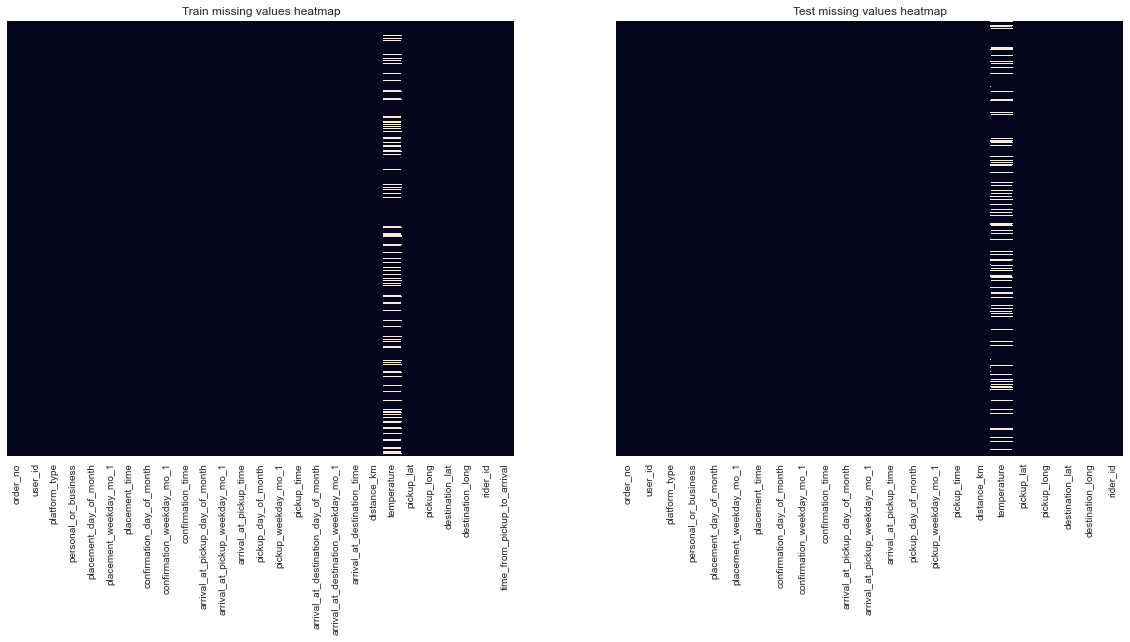

In [10]:
# Addressing columns that have missing values but their percentage is below the threshold value
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(train.isna(), ax = ax[0], yticklabels=False, cbar=False)
sns.heatmap(test.isna(), ax = ax[1], yticklabels=False, cbar=False)
ax[0].set_title('Train missing values heatmap')
ax[1].set_title('Test missing values heatmap')

The Temperature column on both datasets has some missing values. Let's look at the distribution of the temperature values in order to gain good insight towards value imputation. It would be pre-mature to simply the mean or the median since we do not know anything about the distribution of the data. The mean is sensitive to outliers whereas the median is not. Let's look at the distribution.

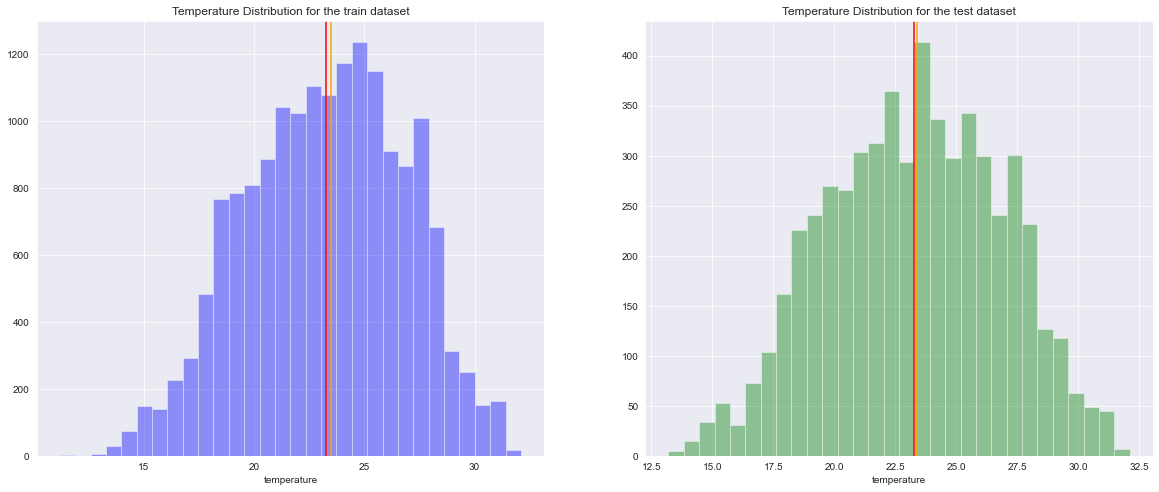

In [11]:
# Temperature distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train['temperature'], bins=30, color='blue', ax = ax[0], kde=False)
sns.distplot(test['temperature'], bins=30, color='green', ax = ax[1], kde=False)
ax[0].set_title('Temperature Distribution for the train dataset')
ax[1].set_title('Temperature Distribution for the test dataset')
ax[0].axvline(x=train['temperature'].mean(), color='red')
ax[0].axvline(x=train['temperature'].median(), color='orange')
ax[1].axvline(x=test['temperature'].mean(), color='red')
ax[1].axvline(x=test['temperature'].median(), color='orange')

The Temperature columns for both datasets are normally distributed thus it would be reasonable to impute the missing values with either the mean or the median value. In this case we will impute the mean.

In [12]:
# Missing values imputation
train['temperature'].fillna(train['temperature'].mean(), inplace=True)
test['temperature'].fillna(test['temperature'].mean(), inplace=True)

### 4.3. Merging Dataframes

In [13]:
# Merging the (train & test) datasets with the riders dataframe on 'Rider Id'
train = pd.merge(train, riders, on='rider_id', how='left')
test = pd.merge(test, riders, on='rider_id', how='left')

In [14]:
display(train.head(3))
display(test.head(3))

,order_no,user_id,platform_type,personal_or_business,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,...,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,time_from_pickup_to_arrival,no_of_orders,age,average_rating,no_of_ratings
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114


,order_no,user_id,platform_type,personal_or_business,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,...,temperature,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,no_of_orders,age,average_rating,no_of_ratings
0,Order_No_19248,User_Id_3355,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,...,23.24612,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_12736,User_Id_3647,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,...,23.24612,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,488,273,14.4,45
2,Order_No_768,User_Id_2154,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,...,22.80000,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,833,460,13.1,67


In [15]:
train.dtypes

order_no                                object
user_id                                 object
platform_type                            int64
personal_or_business                    object
placement_day_of_month                   int64
placement_weekday_mo_1                   int64
placement_time                          object
confirmation_day_of_month                int64
confirmation_weekday_mo_1                int64
confirmation_time                       object
arrival_at_pickup_day_of_month           int64
arrival_at_pickup_weekday_mo_1           int64
arrival_at_pickup_time                  object
pickup_day_of_month                      int64
pickup_weekday_mo_1                      int64
pickup_time                             object
arrival_at_destination_day_of_month      int64
arrival_at_destination_weekday_mo_1      int64
arrival_at_destination_time             object
distance_km                              int64
temperature                            float64
pickup_lat   

## 5. Exploratory Data Analysis

### 5.1. Classifing features according to their datatypes

In [16]:
numeric_columns = []
object_cat_columns = []
time_columns = []
for i, j in train.dtypes.items():
    if (j != object):
        if (i != "time_from_pickup_to_arrival"):
            numeric_columns.append(i)
    elif i.endswith("time"):
        time_columns.append(i)
    else:
        object_cat_columns.append(i)
train[numeric_columns].head(3) 

,platform_type,placement_day_of_month,placement_weekday_mo_1,confirmation_day_of_month,confirmation_weekday_mo_1,arrival_at_pickup_day_of_month,arrival_at_pickup_weekday_mo_1,pickup_day_of_month,pickup_weekday_mo_1,arrival_at_destination_day_of_month,...,distance_km,temperature,pickup_lat,pickup_long,destination_lat,destination_long,no_of_orders,age,average_rating,no_of_ratings
0,3,9,5,9,5,9,5,9,5,9,...,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549
1,3,12,5,12,5,12,5,12,5,12,...,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69
2,3,30,2,30,2,30,2,30,2,30,...,3,23.258889,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114


In [17]:
train[object_cat_columns].head(3)

,order_no,user_id,personal_or_business,rider_id
0,Order_No_4211,User_Id_633,Business,Rider_Id_432
1,Order_No_25375,User_Id_2285,Personal,Rider_Id_856
2,Order_No_1899,User_Id_265,Business,Rider_Id_155


In [18]:
train[time_columns].head(3)

,placement_time,confirmation_time,arrival_at_pickup_time,pickup_time,arrival_at_destination_time
0,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM,10:39:55 AM
1,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM,12:17:22 PM
2,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM,1:00:38 PM


### 5.2. Outliers Overview for numeric features

In [19]:
numeric_columns_new = ['pickup_day_of_month','pickup_weekday_mo_1',
                   'distance_km','temperature','no_of_orders','age','average_rating','no_of_ratings']

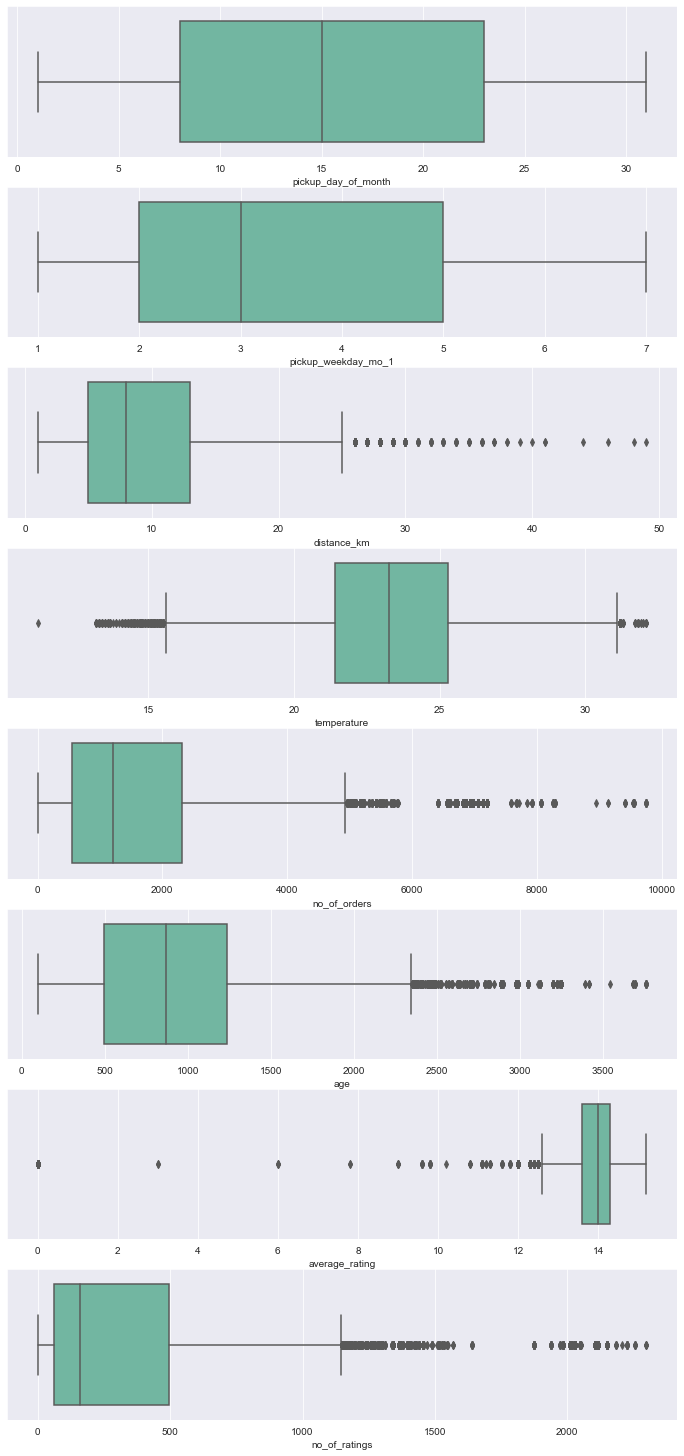

In [20]:
fig, ax = plt.subplots(8,1,figsize=(12,26))
   
for index, column in enumerate(numeric_columns_new):  
    sns.boxplot(train[column], ax=ax[index], palette='Set2')

### 5.3. Correlation between numeric features and the target variable

Since we are dealing with a regression problem it is important to see the correlation between the independent varables and the dependent variable. This can be achieved with the help of a correlation matrix.

In [21]:
correlation_matrix = train[numeric_columns+['time_from_pickup_to_arrival']].corr()
print(correlation_matrix["time_from_pickup_to_arrival"].sort_values(ascending=False))

time_from_pickup_to_arrival            1.000000
distance_km                            0.580608
destination_long                       0.070425
pickup_long                            0.060285
confirmation_weekday_mo_1              0.009744
arrival_at_pickup_weekday_mo_1         0.009744
pickup_weekday_mo_1                    0.009744
arrival_at_destination_weekday_mo_1    0.009744
placement_weekday_mo_1                 0.009693
temperature                            0.005772
no_of_ratings                          0.005609
platform_type                         -0.003827
age                                   -0.007969
arrival_at_destination_day_of_month   -0.014701
pickup_day_of_month                   -0.014701
arrival_at_pickup_day_of_month        -0.014701
confirmation_day_of_month             -0.014701
placement_day_of_month                -0.014710
no_of_orders                          -0.041608
average_rating                        -0.042559
pickup_lat                            -0

There seems to be a strong correlation between the target variable and the distance feature. The rest of the variables do not have such strong correlation with the target variable. 

**Lower correlation** means weak `linear relationship` between the variables but this tells us nothing about their `non-linear` relationship. It would be premature to pass judgement at this level. We will have to further engineer the features and have them in a form that will reveal more information about them.

### 5.4. Examinig the target (time from pickup to arrival at the destination)


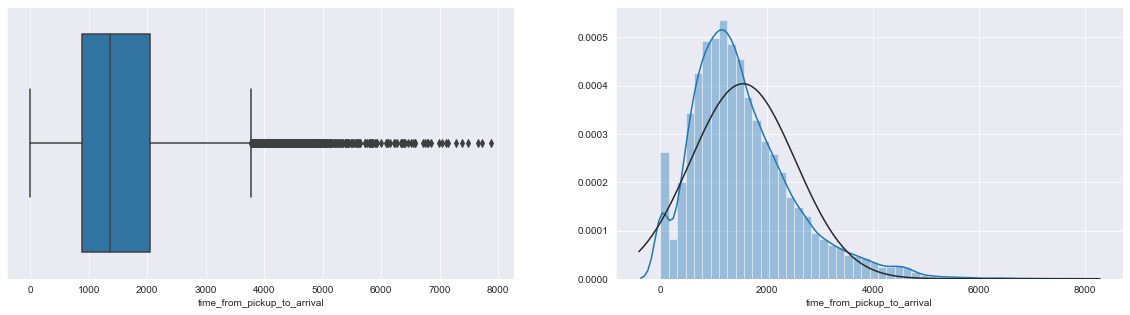

In [22]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(train["time_from_pickup_to_arrival"], ax=ax[0])
sns.distplot(train["time_from_pickup_to_arrival"], fit=norm, ax=ax[1])

The `target variable` is **"positively skewed"** and this is mainly caused by a much lower boundary (meaning there are a minority of very large values) in the dataset. This will affect the regression intercept, coefficients associated with the model. This can be fixed in a number of ways including log transformation and boxcox transform. However, in this case, outliers will be dropped.

## 6. Feature Engineering

### 6.1. Addressing Outliers

Outliers can be filtered out using a `speed` feature. A cutoff speed value will be used to filter outliers.
A maximum speed of about **70 km/h or ~19m/s** will be used as a max threshold value and a minimum speed of **10km/h or 3m/s** as minimum threshold value.

In [23]:
### Calculating the Rider's Speed in m/s
train['speed_meter_per_second'] = (train['distance_km'] * 1000) / train['time_from_pickup_to_arrival']

In [24]:
train['speed_meter_per_second'].describe()

count    21201.000000
mean        69.251494
std        529.249252
min          0.255624
25%          4.573171
50%          6.406834
75%          8.413462
max      17000.000000
Name: speed_meter_per_second, dtype: float64

There's definitely outliers. If not addressed they will affect the performance of our models negatively. However, great care has to be taken when removing outliers because the test data might contain these outliers and our models might not deal accordingly with such.

In [25]:
# train dataset without outliers
train = train[(train['speed_meter_per_second'] <= 18) & (train['speed_meter_per_second'] > 2)]

In [26]:
train['speed_meter_per_second'].describe()

count    19467.000000
mean         6.578756
std          2.615524
min          2.000667
25%          4.674770
50%          6.349206
75%          8.103728
max         17.988553
Name: speed_meter_per_second, dtype: float64

### 6.2. Time Features engineering

The following features will be created out of current Date & Time features:
    
   1. **pick_up_quarter_month**
   2. **pickup_day_month**
   3. **pickup_weekday**
   4. **pickup_hour**
   5. **pickup_minute**
   5. **traffic_hour**
   6. **placement_to_confirmation_diff**
   7. **confirmation_to_arrivalpickup_diff**
   8. **arrivalpickup_to_pickup_diff**

The placement_time and confirmation_time features can either be dropped or be used to create more weighty features. We will attemp to create more features out of these. For instance the duration between these features can add a lot of meaning to the data. It could be that the longer the delay until the picking up of the order means that the rider will strive to prioritize that order in order to make it up to the client for the prior delay. We are just assuming here but the variable selection will prove this assumption true or false.

First let's convert all our time features to datetime format.

In [27]:
def convert_to_datetime(df):
    for col in df.columns:
        if col.endswith("time"):
            df[col] = pd.to_datetime(df[col])
    return df

In [28]:
train = convert_to_datetime(train)
test = convert_to_datetime(test)

In [29]:
# The function classifies the days of the month to their respective quarter of the month
def quarter_of_month(x):
    if x >= 1 and x <= 7:
        return 1
    elif x > 7 and x <= 14:
        return 2
    elif x > 14 and x <= 21:
        return 3
    else:
        return 4
    
#Applying quarter_of_month
train["pick_up_quarter_month"] = train["pickup_day_of_month"].apply(quarter_of_month)
test["pick_up_quarter_month"] = test["pickup_day_of_month"].apply(quarter_of_month)

Text(0.5, 1.0, 'Test data set')

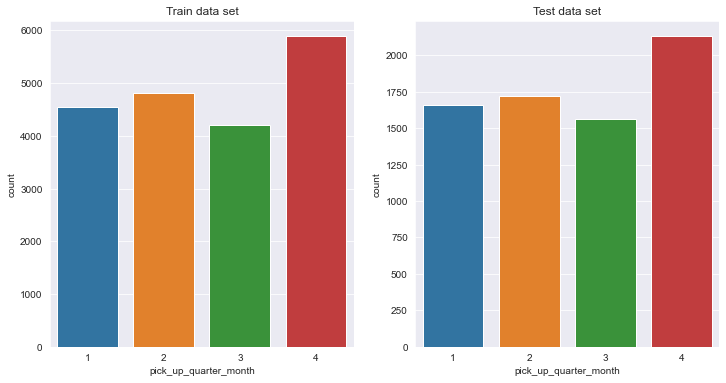

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(train["pick_up_quarter_month"], ax=ax[0])
sns.countplot(test["pick_up_quarter_month"], ax=ax[1])
ax[0].set_title('Train data set')
ax[1].set_title('Test data set')

The countplot above clearly shows that the traffic congestion is not the same throughout the month. In the last week of the month we see an increase in orders made and this means traffic in general does increase. This is a very important insight and it will simplify the learnarity of the model.

Let us also look into the distribution of the pickup weekdays and see if whether the number of orders does vary during the week and on weekend. Our first assumption is that traffic eases during weekends as compared to the middle of the week.

Text(0.5, 1.0, 'Test data set')

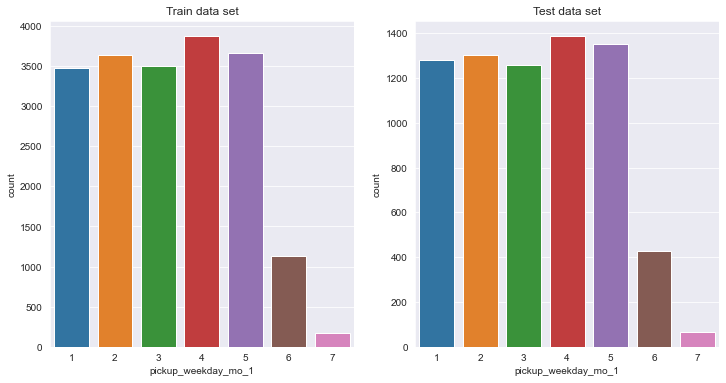

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(train["pickup_weekday_mo_1"], ax=ax[0])
sns.countplot(test["pickup_weekday_mo_1"], ax=ax[1])
ax[0].set_title('Train data set')
ax[1].set_title('Test data set')

Our prediction was true! The number of orders made on weekends is far less than the number of orders made during the week. There isn't much variability in number of orders during the week and this can be problematic to our models. This can be resolved by classifying an order as either falling during the week or on weekend. We will use a binary set of 0 (Not weekend) and 1 (Weekend).

In [32]:
# A function that classifies days as either falling on a weekend or not_weekend
def weekend(x):
    if x <= 5:
        return 1
    else:
        return 0
    
#Applying the not_weekend function to create a new feature
train["weekend"] = train["pickup_weekday_mo_1"].apply(weekend)
test["weekend"] = test["pickup_weekday_mo_1"].apply(weekend)

As for the placement, confirmation and arrival at pickup features, we can choose to ignore them since they more or less resemble the pickup features. However, there could be some correlation between them and the target variable. There could even be some causation. Our imagination tells us that the longer it took for the rider to arrive at the pickup point the higher the order will be prioritized in order to make up for the delay. This could motivate the rider to travel faster that usual. Further analysis will either prove us wrong or right.

We will thus compute the time difference between these features successively.

In [33]:
# train set
train['placement_to_confirmation_diff'] =  (train['confirmation_time'] - train['placement_time']).astype('timedelta64[s]')
train['confirmation_to_arrivalpickup_diff'] = (train['arrival_at_pickup_time'] - train['confirmation_time']).astype('timedelta64[s]')
train['arrivalpickup_to_pickup_diff'] = (train['pickup_time'] - train['arrival_at_pickup_time']).astype('timedelta64[s]')

# test set
test['placement_to_confirmation_diff'] = (test['confirmation_time'] - test['placement_time']).astype('timedelta64[s]')
test['confirmation_to_arrivalpickup_diff'] = (test['arrival_at_pickup_time'] - test['confirmation_time']).astype('timedelta64[s]')
test['arrivalpickup_to_pickup_diff'] = (test['pickup_time'] - test['arrival_at_pickup_time']).astype('timedelta64[s]')

Traffic on the road is one of the high determining factors in terms of one's travel duration from one destination to another. We would expect longer trip durations during breakfast rushhour and also during knockoff rush hour. Traffic should ease during mid hours. With this in mind we will have to make the most out of the **pickup_time** feature. 

Below is the extraction of 'hour', 'minute' and 'second' components of our pickup time

In [34]:
# Extracting the hour and minute component of pickup_time
train['pickup_time'.split('_')[0] + '_hour'] = train['pickup_time'].dt.hour
test['pickup_time'.split('_')[0] + '_hour'] = test['pickup_time'].dt.hour
train['pickup_time'.split('_')[0] + '_minute'] = train['pickup_time'].dt.minute
test['pickup_time'.split('_')[0] + '_minute'] = test['pickup_time'].dt.minute
train['pickup_time'.split('_')[0] + '_second'] = train['pickup_time'].dt.second
test['pickup_time'.split('_')[0] + '_second'] = test['pickup_time'].dt.second

Some of our data is inherently cyclical. Time is a rich example of this: minutes, hours, seconds, day of week, and week of month. All these follow cycles. We have a lot of such features in our data and we want to convey their cyclical nature to our model. But how can we do this? 

The trick is to create two new features, deriving a sine transform and cosine transform. We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using `sin` and `cos` trigonometric functions.

$${x}_{sin} =  {sin}(\frac{2 * \pi * x}{max(x)})$$<br>

$${x}_{cos} =  {cos}(\frac{2 * \pi * x}{max(x)})$$<br>

For us to do that, we need to look at all unique values for every cyclic feature.

In [35]:
print('The unique day values of a month:', sorted(train['pickup_day_of_month'].unique()))
print('The unique weekday values:',sorted(train['pickup_weekday_mo_1'].unique()))
print('The unique hour values:', sorted(train['pickup_hour'].unique()))

The unique day values of a month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
The unique weekday values: [1, 2, 3, 4, 5, 6, 7]
The unique hour values: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [36]:
train['pickup_day_of_month_sin'] = np.sin(train['pickup_day_of_month']*(2.*np.pi/31))
train['pickup_day_of_month_cos'] = np.cos(train['pickup_day_of_month']*(2.*np.pi/31))
train['pickup_weekday_sin'] = np.sin(train['pickup_weekday_mo_1']*(2.*np.pi/7))
train['pickup_weekday_cos'] = np.cos(train['pickup_weekday_mo_1']*(2.*np.pi/7))
train['pickup_hour_sin'] = np.sin(train['pickup_hour']*(2.*np.pi/23))
train['pickup_hour_cos'] = np.cos(train['pickup_hour']*(2.*np.pi/23)) 
train['pickup_minute_sin'] = np.sin(train['pickup_minute']*(2.*np.pi/60)) 
train['pickup_minute_cos'] = np.cos(train['pickup_minute']*(2.*np.pi/60))
train['pickup_second_sin'] = np.sin(train['pickup_second']*(2.*np.pi/60))
train['pickup_second_cos'] = np.cos(train['pickup_second']*(2.*np.pi/60)) 


#Test data set
test['pickup_day_of_month_sin'] = np.sin(test['pickup_day_of_month']*(2.*np.pi/31))
test['pickup_day_of_month_cos'] = np.cos(test['pickup_day_of_month']*(2.*np.pi/31))
test['pickup_weekday_sin'] = np.sin(test['pickup_weekday_mo_1']*(2.*np.pi/7))
test['pickup_weekday_cos'] = np.cos(test['pickup_weekday_mo_1']*(2.*np.pi/7))
test['pickup_hour_sin'] = np.sin(test['pickup_hour']*(2.*np.pi/23)) 
test['pickup_hour_cos'] = np.cos(test['pickup_hour']*(2.*np.pi/23)) 
test['pickup_minute_sin'] = np.sin(test['pickup_minute']*(2.*np.pi/60)) 
test['pickup_minute_cos'] = np.cos(test['pickup_minute']*(2.*np.pi/60)) 
test['pickup_second_sin'] = np.sin(test['pickup_second']*(2.*np.pi/60))
test['pickup_second_cos'] = np.cos(test['pickup_second']*(2.*np.pi/60)) 


if we plot the features in two dimensions, we end up with a perfect cycle (or close to a perfect cycle) for every feature. 

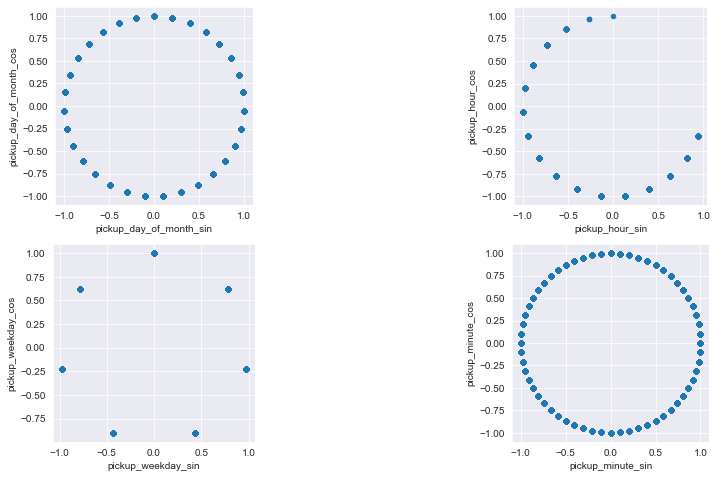

In [37]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
train.plot.scatter('pickup_day_of_month_sin', 'pickup_day_of_month_cos', ax=ax[0,0]).set_aspect('equal')
train.plot.scatter('pickup_hour_sin', 'pickup_hour_cos', ax=ax[0,1]).set_aspect('equal')
train.plot.scatter('pickup_weekday_sin', 'pickup_weekday_cos', ax=ax[1,0]).set_aspect('equal')
train.plot.scatter('pickup_minute_sin', 'pickup_minute_cos', ax=ax[1,1]).set_aspect('equal')


The features can now be used by our machine learning algorithms and as an added benefit, they are also scaled to the range [-1, 1] which will also aid our predictions.

Now that we have encoded our cyclic features we can drop all un-encoded features

In [38]:
time_cols = ['placement_time','arrival_at_pickup_time','pickup_time','confirmation_time']
train.drop(time_cols, axis=1, inplace=True)
test.drop(time_cols, axis=1, inplace=True)

more_train_cols = ['placement_day_of_month','confirmation_day_of_month',
                   'pickup_day_of_month', 'pickup_weekday_mo_1',
                   'arrival_at_pickup_day_of_month','arrival_at_pickup_weekday_mo_1',
                   'placement_weekday_mo_1','confirmation_weekday_mo_1',
                   'pickup_minute','arrival_at_destination_day_of_month', 
                   'arrival_at_destination_weekday_mo_1', 'pickup_hour', 'pickup_second']

more_test_cols = ['placement_day_of_month','confirmation_day_of_month',
                  'pickup_day_of_month', 'pickup_weekday_mo_1',
                  'arrival_at_pickup_day_of_month','arrival_at_pickup_weekday_mo_1',
                  'placement_weekday_mo_1','confirmation_weekday_mo_1',
                  'pickup_minute', 'pickup_hour','pickup_second']

train.drop(more_train_cols, axis=1, inplace=True)
test.drop(more_test_cols, axis=1, inplace=True)

### 6.3. Rider's Features engineering

#### 6.3.1. Rider's Rating & Productivity

Dimensionality reduction is always a good thing provided we preserve the information. We can do so even with rider's features. Some of the rider's features are a bit obscure but with proper engineering they can add much value to the modellling. We do this by creating a feature called `rating_factor` which is the product of `average rating` and `number of ratings`. Another feature we create is `rider_productivity` feature, which is a ratio of `rider's age` to `number of orders`.

This will help normalize the rider's features. For example, you might find that one rider has a high average rating but few number of ratings. On the other hand, one rider has a slightly lower rating with many ratings. At face value one would think the rider with higher average rating is better than the one with a slightly lower rating. However, this is necessarily not the case. To deal with such issues we combine both the rating and number of ratings. The same applies with age and number of orders. 

In [39]:
#Creating new variables that will measure the Rider's Rating and Productivity
train.loc[:, 'rating_factor'] = (train['average_rating'] * train['no_of_ratings'])
test.loc[:, 'rating_factor'] = (test['average_rating'] * test['no_of_ratings'])
train.loc[:, 'rider_productivity'] = (train['age'] / train['no_of_orders'])
test.loc[:, 'rider_productivity'] = (test['age'] / test['no_of_orders'])

#### 6.3.2. Rider's Id uniqueness

Furthermore let us explore the uniqueness of the **Rider's Id** feature. It is of great interest to know how many unique riders are found on both datasets and how many are not. From this we will be able to decide whether the Rider's Id can add value to our models or not.

In [40]:
print('The train dataset has', train['rider_id'].nunique(), 'unique riders.')
print('The test dataset has', test['rider_id'].nunique(), 'unique riders.')
how_many = len(set([rider for rider in test['rider_id'] if rider in train['rider_id'].unique()]))
print('Both datasets share', how_many, 'unique riders')

The train dataset has 919 unique riders.
The test dataset has 822 unique riders.
Both datasets share 792 unique riders


From the above analysis it is clear that the rider's id feature cannot be dropped since both datasets share the majority of riders. Each rider is unique and this will add weight to the modelling.

#### 6.3.3. Rider's average speed

It is important that we create another feature that will give us insight into the rider's general performance in terms of how fast or slow the rider is. This will provide our models with a good frame of reference when predicting the trip duration for every order done by a specific rider.

In [41]:
train['average_rider_speed'] = train['rider_id'].map(train.groupby('rider_id')['speed_meter_per_second'].mean())
test['average_rider_speed'] = test['rider_id'].map(train.groupby('rider_id')['speed_meter_per_second'].mean())

We have seen that the two datasets do not exactly have same riders thus the above computation will result in the `average_rider_speed` in the test set having null values. The null values will be imputed with the average_rider_speed from the train dataset.

In [42]:
test['average_rider_speed'].fillna(train['speed_meter_per_second'].mean(), inplace=True)

### 6.4. Geospatial Features engineering

Needless to say, the two most important geospatial features to any travel time prediction problem are distance, and direction.

#### 6.4.1. Haversine distance

We are going to feature a measure of distance between pick-up and drop-off coordinates namely Haversine distance and. This approach is highly encouraged by many independent studies on travel time prediction and optimization.

Due to the spherical shape of the earth, when travelling between two points, we are not traversing in a straight line, but rather on a curvature. To consider that curvature distance (which is different than euclidean distance), `Haversine` distance is calculated.

In [43]:
def haversine(pick_lat, pick_long, drop_lat, drop_long):
    """
    Calculate the circle distance between two points 
    on the earth (specified in decimal degrees)
    """
   # approximate radius of earth in km
    R = 6373.0
    
    # Converting degrees to radians
    pick_lat = np.deg2rad(pick_lat)                     
    pick_long = np.deg2rad(pick_long)     
    drop_lat = np.deg2rad(drop_lat)                       
    drop_long = np.deg2rad(drop_long)  

    dist = np.sin((drop_lat - pick_lat)/2)**2 + np.cos(pick_lat)*np.cos(drop_lat) * np.sin((drop_long - pick_long)/2)**2

    return 2 * R * np.arcsin(np.sqrt(dist))

In [44]:
train.loc[:, 'distance_haversine'] = haversine(train['pickup_lat'].values, train['pickup_long'].values, train['destination_lat'].values, train['destination_long'].values)
test.loc[:, 'distance_haversine'] = haversine(test['pickup_lat'].values, test['pickup_long'].values, test['destination_lat'].values, test['destination_long'].values)


In [45]:
train["min_distance_pick_to_arrival"] = train.apply(lambda x: vincenty((x["pickup_lat"], x["pickup_long"]), (x["destination_lat"], x["destination_long"])).kilometers, axis = 1)
test["min_distance_pick_to_arrival"] = test.apply(lambda x: vincenty((x["pickup_lat"], x["pickup_long"]), (x["destination_lat"], x["destination_long"])).kilometers, axis = 1)
train["excess_distance"] = train["distance_km"] - train["min_distance_pick_to_arrival"]
test["excess_distance"] = test["distance_km"] - test["min_distance_pick_to_arrival"]

#### 6.4.2. Direction

As mentioned already, direction or bearing, does play a huge role in navigation and in travel time prediction. Bearing can be defined as direction or an angle, between the north-south line of earth and the line connecting the target (destination) and the reference point while heading is an angle or direction where you are currently navigating in. Therefore in order to get to a particular destination one needs to adjust their heading direction with the bearing. Below we calculate the direction of the trips.

In [46]:
def bearing_array(lat1, long1, lat2, long2):
    '''
    The function calculates the direction bearing of the given coordinates
    '''
    long_delta_rad = np.radians(long2 - long1)
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    y = np.sin(long_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(long_delta_rad)
    angle = np.degrees(np.arctan2(y, x))
    return angle

In [47]:
#Calculating the direction of the destination by applying bearing_array func on the coordinates
train.loc[:, 'direction'] = bearing_array(train['pickup_lat'].values, train['pickup_long'].values, train['destination_lat'].values, train['destination_long'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_lat'].values, test['pickup_long'].values, test['destination_lat'].values, test['destination_long'].values)

#### 6.4.3. Principal Component Analysis (PCA)

The chief idea behind **PCA** is to reduce the dimensionality of the data set, while retaining as much as possible of the variation present in the data set.

In this study, we use PCA to extract features related to latitude and longitude to improve our regressor’s learnability.

It has been proven that PCA features can improve decision tree splitting [Nasution, Sitompul, & Ramli, 2018](https://www.sciencedirect.com/science/article/pii/S0957417419305743#bib0025)

In [48]:
coordinates = np.vstack((train[['pickup_lat', 'pickup_long']].values,
                    train[['destination_lat', 'destination_long']].values))

pca = PCA(random_state=rs).fit(coordinates) #Instance
# Train data transformation
train['pickup_pca_0'] = pca.transform(train[['pickup_lat', 'pickup_long']])[:, 0]
train['pickup_pca_1'] = pca.transform(train[['pickup_lat', 'pickup_long']])[:, 1]
train['dropoff_pca_0'] = pca.transform(train[['destination_lat', 'destination_long']])[:, 0]
train['dropoff_pca_1'] = pca.transform(train[['destination_lat', 'destination_long']])[:, 1]
# Test data transformation
test['pickup_pca_0'] = pca.transform(test[['pickup_lat', 'pickup_long']])[:, 0]
test['pickup_pca_1'] = pca.transform(test[['pickup_lat', 'pickup_long']])[:, 1]
test['dropoff_pca_0'] = pca.transform(test[['destination_lat', 'destination_long']])[:, 0]
test['dropoff_pca_1'] = pca.transform(test[['destination_lat', 'destination_long']])[:, 1]

#### 6.4.4. Cluster analysis on Coordinates

Besides PCA, we have implemented a version of KMeans clustering algorithm which initializes centroids by probabilities that maximize expected centroids’ distance and uses Manhattan distance as loss function.

Clusters capture the natural structure of the data and thus help our algorithms to do a better job at predicting the target feature. In this case we will create pickup clusters and drop off clusters that will increase the accuracy of our predictions as the models will be able to relate every observation to its relevant cluster. This will be done using the scikit-learn `MiniBatchKMeans`

In [49]:
#performing our own clustering on all the points pickup/destination in the data using KMeans
coordinates = np.vstack((train[['pickup_lat', 'pickup_long']].values,
                    train[['destination_lat', 'destination_long']].values))

Kmeans = MiniBatchKMeans(n_clusters=14, batch_size=1000,random_state=rs) #Instance
Kmeans.fit(coordinates[np.arange(0, len(coordinates), 1)]) # fitting
train['pickup_cluster'] = Kmeans.predict(train[['pickup_lat', 'pickup_long']])
train['dropoff_cluster'] = Kmeans.predict(train[['destination_lat', 'destination_long']])
test['pickup_cluster'] = Kmeans.predict(test[['pickup_lat', 'pickup_long']])
test['dropoff_cluster'] = Kmeans.predict(test[['destination_lat', 'destination_long']])
train['center_latitude'] = (train['pickup_lat'].values + train['destination_lat'].values) / 2
train['center_longitude'] = (train['pickup_long'].values + train['destination_long'].values) / 2
test['center_latitude'] = (test['pickup_lat'].values + test['destination_lat'].values) / 2
test['center_longitude'] = (test['pickup_long'].values + test['destination_long'].values) / 2

In [50]:
import plotly.express as px
# There is a .mapbox_token file containing a mapbox token in the same directory as the dataframe
px.set_mapbox_access_token(open(".mapbox_token").read()) #opening the file
fig = px.scatter_mapbox(train, lat="pickup_lat", lon="pickup_long", color="pickup_cluster",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

ModuleNotFoundError: No module named 'plotly.express'

### 6.5. Variable Encoding

Let us once more take a look into our features

In [ ]:
display(train.columns)
display(test.columns)

In [ ]:
# How do  our datasets vary in features
for col in train.columns:
    if col not in test.columns:
        print(col)

In [ ]:
# This is justified in the distplot of the target variable.
train=train[train['time_from_pickup_to_arrival']<=5000] #Filtering out severe outliers

sns.distplot(train['time_from_pickup_to_arrival'], bins=30)

In [ ]:
# Dropping all the columns we will no longer need in the predictors (X) data
train_cols_drop = ['order_no', 'user_id','no_of_orders','distance_km', 'age','no_of_ratings', 
                   'average_rating','min_distance_pick_to_arrival', 'speed_meter_per_second','arrival_at_destination_time', 
                   'time_from_pickup_to_arrival']

test_cols_drop = ['order_no','user_id','no_of_orders','min_distance_pick_to_arrival', 'no_of_ratings', 
                  'age', 'average_rating', 'distance_km']

train['platform_type'] = train['platform_type'].astype('category')
test['platform_type'] = test['platform_type'].astype('category')

y_data = train['time_from_pickup_to_arrival']# Target variable
X_data = train.drop(train_cols_drop, axis=1) #Predictors
X_test_data = test.drop(test_cols_drop, axis=1)
X_test_order_no = test['order_no']

Let's one last time check if the datasets have matching features

In [ ]:
display(X_test_data.columns == X_data.columns) 

Since some of our features are in categorical/object form, we cannot yet feed the data into a machine learning algorithm, we need to encode them. We will employ `One-hot encoder` for that. `One-hot encoding` is one of the most common encoding methods in machine learning. This method spreads the values in a column to multiple flag columns and assigns 0 or 1 to them. These binary values express the relationship between grouped and encoded column.

This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information. 

`OneHotEncoder` is preferred over pandas `get_dummies`. The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.

In [ ]:
#Feature Encoding
oce = ce.OneHotEncoder(cols=['platform_type','personal_or_business'])
hce = ce.TargetEncoder(cols=['rider_id'], smoothing = 40, min_samples_leaf = 7)

X_data = oce.fit_transform(X_data)
X_data = hce.fit_transform(X_data,y_data)
X_test_data = oce.transform(X_test_data)
X_test_data = hce.transform(X_test_data)

### 6.6. Feature Selection and Correlation

In [ ]:
# Normalize data
def variance_selection(p_value):
    X_data_2 = X_data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_data_2)
    X_normalize = pd.DataFrame(X_scaled, columns=X_data_2.columns)

    # Create VarianceThreshold object
    selector = VarianceThreshold(threshold=0.05)

    # Use the object to apply the threshold on data
    selector.fit(X_normalize)

    # Get column variances
    column_variances = selector.variances_

    vars_dict = {}
    vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
                for c_name, c_var in zip(X_normalize.columns, column_variances)]
    df_vars = pd.DataFrame(vars_dict)
    select_df = df_vars[df_vars['Variance'] <= p_value].sort_values(by='Variance', ascending=False)
    return select_df
variance_selection(0.05)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(z = X_data.corr().values, x = X_data.columns, y = X_data.columns, hoverongaps = False))
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue"
)
fig.show()

In [ ]:
X_data.drop('personal_or_business_2', axis=1, inplace=True)
X_test_data.drop('personal_or_business_2', axis=1, inplace=True)

## 7. Model Selection & Parameter Tuning

Before we go ahead and build models we want each model to perform at its best and to fit the data to the best of its abilities. This calls for parameter hypertuning. We will tune all our select models except linear regression.


### 7.1. Our Base Models & HyperParameter Tuning

* The Linear Regression model

When building a linear regression model we do not have to include unnecessary features that do not contribute reasonably to the change in the predicted variable.

We will implement backward elimination, whereby we will deselect features that p-value greater than 0.05 being interpreted as a failure to explain the change in the target variable either than just chance. Our linear regression model will be fitted on these. 

RobustScaler will be coupled with our model in order to deal with outliers.

In [ ]:
lin_reg = make_pipeline(RobustScaler(), LinearRegression())

* Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [ ]:

# Gradient Boosting Regressor
params = [{'max_depth': [5], #[6, 8, 10]
           'learning_rate':[0.05], #[0.001, 0.05, 0.1]
           'n_estimators': [300], #[100, 200, 400]
           'loss':['huber'],
           'max_features':['auto'],
           'min_samples_leaf':[16], #[14, 15, 17]
           'min_samples_split':[10]}] #[12, 15]

gbr = GridSearchCV(GradientBoostingRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
gbrm = gbr.fit(X_data, y_data)

print(gbrm.best_params_, np.sqrt(abs(gbrm.best_score_)))


{'learning_rate': 0.17, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 576.0986013100938

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 567.
4564855799742

{'learning_rate': 0.17, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200} 573.1216768860124

* Decision Tree Regressor:




In [ ]:
# Decision Tree
params = [{'max_depth': [1,2,3,4,5,10,20,50]}]
dtree = GridSearchCV(DecisionTreeRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
dtreem = dtree.fit(X_data, y_data)

print(dtreem.best_params_, np.sqrt(abs(dtreem.best_score_)))

* Random Forest Regressor

In [ ]:
# Random Forests
params = [{'max_depth': [5], #, [10, 15, 20, 50]
               'n_estimators': [200, 300]}] #[10, 25, 50, 100,150]

rfr = GridSearchCV(RandomForestRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
rfrm = rfr.fit(X_data, y_data)

print(rfrm.best_params_, np.sqrt(abs(rfrm.best_score_)))

* AdaBoost Regressor:

In [ ]:
# AdaBoost
params = [{'learning_rate': [0.05,0.1], #[0.001, 0.01, 0.2]
            'n_estimators': [300, 400]}] #[100, 200]

ada = GridSearchCV(AdaBoostRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
adam = ada.fit(X_data, y_data)

print(ada.best_params_, np.sqrt(abs(ada.best_score_)))

* Catboost Regressor

In [ ]:
params = {
    'n_estimators':[420], #[250, 300, 420]
    'max_depth': [5], #[4,6]
    'learning_rate': [0.18],#[0.04, 0.05, 0.1, 0.15]
    'colsample_bylevel':[0.6], #[0.5]
    'l2_leaf_reg':[5],#[1, 2, 6] 
    'subsample':[0.9]} #[0.7, 0.8]


cat = GridSearchCV(CatBoostRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
catm = cat.fit(X_data, y_data)

print(catm.best_params_, np.sqrt(abs(catm.best_score_)))


## 8. Model Evaluation

### 8.1. Cross Validation Scheme

We will start by applying the cross validation scheme on our base models using default parameters.

In [ ]:
# Instantiating the cross validation scheme
kfold = KFold(n_splits=10, random_state=10, shuffle=True)

In [ ]:
regressors = []
regressors.append(lin_reg)
regressors.append(gbrm.best_estimator_)
regressors.append(dtreem.best_estimator_)
regressors.append(rfrm.best_estimator_)
regressors.append(adam.best_estimator_)
regressors.append(catm.best_estimator_)

In [ ]:
cross_val_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cross_val_results.append(np.sqrt(abs(cross_val_score(regressor, X_data, y=y_data, scoring='neg_mean_squared_error', cv=kfold))))

cross_val_means = []
cross_val_stds = []
for cross_val_result in cross_val_results:
    cross_val_means.append(cross_val_result.mean())
    cross_val_stds.append(cross_val_result.std())
    
cross_val_res = pd.DataFrame({ 
    "Algorithm": ["LinearRegression", "GradientBoostingRegression", "DecisionTreeRegression", "RandomForestRegression", "AdaBoostRegression", 'CatBoostRegression'],
    "CrossValidationMeans": cross_val_means, "CrossValidationErrors": cross_val_stds
                       })
cross_val_res = cross_val_res.sort_values("CrossValidationMeans", ascending=True)
print(cross_val_res)

### 8.2. Final Models

From the six models we started with, only two were selected for further predictions. The selection was done on the basis of the RMSE results obtained from the above cross validation.  The top two selected are Gradient Boosting Regressor and CatBoost Regressor.

In [ ]:
model_bag_gbr= GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=5, loss='huber',max_features='auto', 
                                   min_samples_leaf=15, min_samples_split=10,random_state = rs)

model_bag_cat=BaggingRegressor(CatBoostRegressor(max_depth=5,learning_rate=0.18,
                                                 n_estimators=420,loss_function='RMSE',
                                                colsample_bylevel=0.6,l2_leaf_reg=2,
                                                 subsample=0.9,random_state=rs),random_state=rs)


### 8.3. Making Predictions

In [ ]:
# The function fits our models
def model_fitting(model, model_name, X, y):   
    train_fold = np.zeros((len(X_data)))
    test_fold = np.zeros((len(X_test_data)))
    cross_val_scores = [] 
    training_scores=[]
    testing_scores=[]
    for index, (train_index, test_index) in (enumerate(kfold.split(X, y))): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test_data) 
        test_fold += test_pred 
        train_fold[test_index] += y_pred
        cross_validation_RMSE = np.sqrt(MSE(y_test, y_pred))
        train_RMSE = np.sqrt(MSE(y_train, train_pred))
        training_scores.append(train_RMSE)
        cross_val_scores.append(cross_validation_RMSE)
        print(f'Iteration {index + 1} is done with RMSE of {cross_validation_RMSE}')
    final_training_score = np.mean(training_scores)
    final_cross_val_score = np.mean(cross_val_scores)

    print(f'final_training_score : {final_training_score} -  final_cross_val_score : {final_cross_val_score} ')
    
    return train_fold, test_fold/10

In [ ]:
train_fold_1, test_fold_1 = model_fitting(model_bag_gbr, 'GradientBoostRegressor', X_data, y_data)

In [ ]:
train_fold_2, test_fold_2 = model_fitting(model_bag_cat, 'CatBoostRegressor', X_data, y_data)

### 8.4. Feature Relative Importance

In [ ]:
def relative_importance(X, model):
    vals = model.feature_importances_ # Extracting feature importance
    l_importance = np.array([val / sum(vals) for val in vals])

    features = X.columns

    feats = np.array(features)

    fig,ax = plt.subplots(figsize=(12, 12))
    plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

    indices = np.argsort(l_importance)[::-1]
    g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=ax)
    g.set_xlabel("Relative importances", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(" Model feature importance")

In [ ]:
relative_importance(X_data, model_bag_gbr)

## 9. Submission

We use the train predictions from the cross validation to optimize the test data submission.

In [ ]:
new_list = []
for i in np.linspace(0, 1, 100):
    y_train_average = train_fold_1 * i + train_fold_2 * (1 - i)
    error = np.sqrt(MSE(y_data, y_train_average))
    new_list.append(error)
px.line(x = np.linspace(0, 1, 100), y = new_list)

In [ ]:
averaged_models_y = test_fold_1 * 0.2828 + test_fold_2 * (1 - 0.2828)
averaged_models_output = pd.DataFrame({"Order_No":X_test_order_no, 
                           "Time from Pickup to Arrival": averaged_models_y})
averaged_models_output.to_csv("Submission.csv", index=False)

In [ ]:
df = pd.read_csv("Submission.csv")
df.head()

### Model Pickling

In [ ]:
import pickle

model_save_path = "s_reg_A.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model_bag_gbr,file)

model_save_path = "s_reg__B.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model_bag_cat,file)

## 10. References

1. [An integrated feature learning approach using deep learning for travel time prediction](https://doi.org/10.1016/j.eswa.2019.112864).

2. https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

3. https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

4. https://towardsdatascience.com/finding-the-right-model-parameters-3670a1c086b3

5. https://github.com/frex1/Regression-Model/blob/master/reg_comp.ipynb

6. https://www.researchgate.net/publication/221019852_Development_of_an_Effective_Travel_Time_Prediction_Method_Using_Modified_Moving_Average_Approach

7. https://ieeexplore.ieee.org/document/8622970

8. https://github.com/deepVector/geospatial-machine-learning

9. https://towardsdatascience.com/think-twice-before-you-use-principal-component-analysis-in-supervised-learning-tasks-70fbb68ebd0c

10. https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab

11. https://medium.com/@mandava807/cross-validation-and-hyperparameter-tuning-in-python-65cfb80ee485

12. https://github.com/vlazovskiy/route-optimizer-machine-learning/blob/master/Train%20LightGBM%20Model.ipynb

13. https://www.researchgate.net/publication/257435756_Identifying_important_variables_for_predicting_travel_time_of_freeway_with_non-recurrent_congestion_with_neural_networks

14. https://github.com/Kailash23/forecast-delivery-time

15. https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

16. https://github.com/AmrKhalifa/Zindi-Sendy-Logistics-Challenge